In [22]:
# install dependencies
!pip install flax optax

In [23]:
import jax
import jax.numpy as jnp

import jax.lax as lax
from jax import random, jit

import optax

import flax
from flax import linen as nn

from functools import partial

import torchvision

import numpy as np  # TO DO remove np's -> jnp
import contextlib

from typing import Tuple, Union, List, OrderedDict, Callable, Any
from dataclasses import field

# jaxopt has already implicit differentiation!!
import time

from matplotlib import pyplot as plt


In [26]:
# utility function for local random seeding
@contextlib.contextmanager
def np_temp_seed(seed):
	state = np.random.get_state()
	np.random.seed(seed)
	try:
		yield
	finally:
		np.random.set_state(state)

DEQ idea & finding stationary points with root finder, maybe root finder demo on small example (but that's close to copying from last year so maybe smth different?)

In [27]:
def _safe_norm_jax(v):
    if not jnp.all(jnp.isfinite(v)):
        return jnp.inf
    return jnp.linalg.norm(v)

def scalar_search_armijo_jax(phi, phi0, derphi0, c1=1e-4, alpha0=1, amin=0):
    # adapted from https://github.com/locuslab/deq/blob/master/lib/solvers.py
    ite = 0
    phi_a0 = phi(alpha0)    # First do an update with step size 1
    if phi_a0 <= phi0 + c1*alpha0*derphi0:
        return alpha0, phi_a0, ite

    # Otherwise, compute the minimizer of a quadratic interpolant
    alpha1 = -(derphi0) * alpha0**2 / 2.0 / (phi_a0 - phi0 - derphi0 * alpha0)
    phi_a1 = phi(alpha1)

    # Otherwise loop with cubic interpolation until we find an alpha which
    # satisfies the first Wolfe condition (since we are backtracking, we will
    # assume that the value of alpha is not too small and satisfies the second
    # condition.
    while alpha1 > amin:       # we are assuming alpha>0 is a descent direction
        factor = alpha0**2 * alpha1**2 * (alpha1-alpha0)
        a = alpha0**2 * (phi_a1 - phi0 - derphi0*alpha1) - \
            alpha1**2 * (phi_a0 - phi0 - derphi0*alpha0)
        a = a / factor
        b = -alpha0**3 * (phi_a1 - phi0 - derphi0*alpha1) + \
            alpha1**3 * (phi_a0 - phi0 - derphi0*alpha0)
        b = b / factor

        alpha2 = (-b + jnp.sqrt(jnp.abs(b**2 - 3 * a * derphi0))) / (3.0*a)
        phi_a2 = phi(alpha2)
        ite += 1

        if (phi_a2 <= phi0 + c1*alpha2*derphi0):
            return alpha2, phi_a2, ite

        if (alpha1 - alpha2) > alpha1 / 2.0 or (1 - alpha2/alpha1) < 0.96:
            alpha2 = alpha1 / 2.0

        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi_a2

    # Failed to find a suitable step length
    return None, phi_a1, ite


def line_search_jax(update, x0, g0, g, nstep=0, on=True):
    # adapted from https://github.com/locuslab/deq/blob/master/lib/solvers.py
    """
    `update` is the propsoed direction of update.

    Code adapted from scipy.
    """
    tmp_s = [0]
    tmp_g0 = [g0]
    tmp_phi = [jnp.linalg.norm(g0)**2]
    s_norm = jnp.linalg.norm(x0) / jnp.linalg.norm(update)

    def phi(s, store=True):
        if s == tmp_s[0]:
            return tmp_phi[0]    # If the step size is so small... just return something
        x_est = x0 + s * update
        g0_new = g(x_est)
        phi_new = _safe_norm_jax(g0_new)**2
        if store:
            tmp_s[0] = s
            tmp_g0[0] = g0_new
            tmp_phi[0] = phi_new
        return phi_new
    
    if on:
        s, phi1, ite = scalar_search_armijo_jax(phi, tmp_phi[0], -tmp_phi[0], amin=1e-2)
    if (not on) or s is None:
        s = 1.0
        ite = 0

    x_est = x0 + s * update
    if s == tmp_s[0]:
        g0_new = tmp_g0[0]
    else:
        g0_new = g(x_est)
    return x_est, g0_new, x_est - x0, g0_new - g0, ite



In [28]:
def rmatvec_jax(part_Us, part_VTs, x):
    # adapted from https://github.com/locuslab/deq/blob/master/lib/solvers.py
    if jnp.size(part_Us) == 0:
        return -x
    xTU = jnp.einsum('bij, bijd -> bd', x, part_Us)   # (N, threshold)
    return -x + jnp.einsum('bd, bdij -> bij', xTU, part_VTs)    # (N, 2d, L'), but should really be (N, 1, (2d*L'))

def matvec_jax(part_Us, part_VTs, x):
    # adapted from https://github.com/locuslab/deq/blob/master/lib/solvers.py
    if jnp.size(part_Us) == 0:
        return -x
    VTx = jnp.einsum('bdij, bij -> bd', part_VTs, x)  # (N, threshold)
    return -x + jnp.einsum('bijd, bd -> bij', part_Us, VTx)     # (N, 2d, L'), but should really be (N, (2d*L'), 1)


In [29]:
def broyden_jax(f, z0, x0, threshold, eps=1e-3, stop_mode="rel", result_dict=False, ls=False):
    # adapted from https://github.com/locuslab/deq/blob/master/lib/solvers.py
    bsz, total_hsize = z0.shape
    orig_shape = (bsz,total_hsize)
    seq_len = 1
    new_shape = (bsz,total_hsize,seq_len)
    z0 = z0.reshape(*new_shape)
    def g(_z):
        # here it is safe to use x out of scope
        return (f(_z.reshape(*orig_shape),x0)-_z.reshape(*orig_shape)).reshape(*new_shape)
    dev = z0.device()
    alternative_mode = 'rel' if stop_mode == 'abs' else 'abs'
    
    z_est = z0           # (bsz, 2d, L')
    gz = g(z_est)        # (bsz, 2d, L')
    nstep = 0
    tnstep = 0
    
    # For fast calculation of inv_jacobian (approximately)
    Us = jax.device_put(jnp.zeros((bsz, total_hsize, seq_len, threshold)),dev)     # One can also use an L-BFGS scheme to further reduce memory
    VTs = jax.device_put(jnp.zeros((bsz, threshold, total_hsize, seq_len)),dev)
    update = -matvec_jax(Us[:,:,:,:nstep], VTs[:,:nstep], gz)      # Formally should be -torch.matmul(inv_jacobian (-I), gx)
    prot_break = False
    
    # To be used in protective breaks
    protect_thres = (1e6 if stop_mode == "abs" else 1e3) * seq_len
    new_objective = 1e8

    trace_dict = {'abs': [],
                  'rel': []}
    lowest_dict = {'abs': 1e8,
                   'rel': 1e8}
    lowest_step_dict = {'abs': 0,
                        'rel': 0}
    nstep, lowest_zest, lowest_gz = 0, z_est, gz

    while nstep < threshold:
        z_est, gz, delta_z, delta_gz, ite = line_search_jax(update, z_est, gz, g, nstep=nstep, on=ls)
        nstep += 1
        tnstep += (ite+1)
        abs_diff = jnp.linalg.norm(gz)
        rel_diff = abs_diff / (jnp.linalg.norm(gz + z_est) + 1e-9)
        diff_dict = {'abs': abs_diff,
                     'rel': rel_diff}
        trace_dict['abs'].append(abs_diff)
        trace_dict['rel'].append(rel_diff)
        for mode in ['rel', 'abs']:
            if diff_dict[mode] < lowest_dict[mode]:
                if mode == stop_mode: 
                    lowest_zest, lowest_gz = jnp.copy(z_est), jnp.copy(gz)
                lowest_dict[mode] = diff_dict[mode]
                lowest_step_dict[mode] = nstep

        new_objective = diff_dict[stop_mode]
        if new_objective < eps: break
        if new_objective < 3*eps and nstep > 30 and np.max(trace_dict[stop_mode][-30:]) / np.min(trace_dict[stop_mode][-30:]) < 1.3:
            # if there's hardly been any progress in the last 30 steps
            break
        if new_objective > trace_dict[stop_mode][0] * protect_thres:
            prot_break = True
            break

        part_Us, part_VTs = Us[:,:,:,:nstep-1], VTs[:,:nstep-1]
        vT = rmatvec_jax(part_Us, part_VTs, delta_z)
        u = (delta_z - matvec_jax(part_Us, part_VTs, delta_gz)) / jnp.einsum('bij, bij -> b', vT, delta_gz)[:,None,None]
        vT = jnp.nan_to_num(vT,nan=0.)
        u = jnp.nan_to_num(u,nan=0.)
        VTs = VTs.at[:,nstep-1].set(vT)
        Us = Us.at[:,:,:,nstep-1].set(u)
        update = -matvec_jax(Us[:,:,:,:nstep], VTs[:,:nstep], gz)

    # Fill everything up to the threshold length
    for _ in range(threshold+1-len(trace_dict[stop_mode])):
        trace_dict[stop_mode].append(lowest_dict[stop_mode])
        trace_dict[alternative_mode].append(lowest_dict[alternative_mode])

    lowest_zest = lowest_zest.reshape(*orig_shape)
    # print("broyden",jnp.linalg.norm(z_est),jnp.linalg.norm(gz))

    if result_dict:
        return {"result": lowest_zest,
                "lowest": lowest_dict[stop_mode],
                "nstep": lowest_step_dict[stop_mode],
                "prot_break": prot_break,
                "abs_trace": trace_dict['abs'],
                "rel_trace": trace_dict['rel'],
                "eps": eps,
                "threshold": threshold}
    else:
        return lowest_zest


def newton_jax(f, z0, x0, threshold, eps=1e-3):

    # note: f might ignore x0 (i.e. with backward pass)
    orig_shape = z0.shape
    def g(_z):
      # this reshaping is to enable solving with Jacobian
      return (f(_z.reshape(*orig_shape),x0)-_z.reshape(*orig_shape)).reshape(-1)
    jac_g = jax.jacfwd(g)
    z = z0.reshape(-1)
    gz = g(z)
    gz_norm = jnp.linalg.norm(gz)
    nstep = 0

    while nstep < threshold and gz_norm > eps:
      # solve system
      jgz = jac_g(z)
      # print("gz",gz.shape,jnp.linalg.norm(gz))
      # print("jgz",jgz.shape,jnp.linalg.norm(jgz))
      delta_z = jnp.linalg.solve(jgz,-gz)
      # print("delta_z",delta_z.shape,jnp.linalg.norm(delta_z))
      z = z + delta_z
      # need to compute gx here to decide whether to stop
      gz = g(z)
      gz_norm = jnp.linalg.norm(gz)
      nstep += 1

    z = z.reshape(*orig_shape).astype(jnp.float32)

    return z

def direct_jax(f, z0, x0, threshold, eps=1e-3):

    nstep = 0
    z_old = z0
    z_new = f(z0,x0)
    gz = z_new-z_old
    gz_norm = jnp.linalg.norm(gz)
    min_gz_norm, min_z = gz_norm, z_new
    while nstep < threshold and gz_norm > eps:
      z_old = z_new
      z_new = f(z_old,x0)
      gz = z_new-z_old
      gz_norm = jnp.linalg.norm(gz)
      if gz_norm < min_gz_norm:
        min_gz_norm, min_z = gz_norm, z_new
      nstep += 1
    # print("min_gz_norm",min_gz_norm,"nstep",nstep)
    return min_z


In [30]:
class MDEQBlock(nn.Module):
    curr_branch: int
    channels: List[int]
    kernel_size: Tuple[int] = (3, 3) 
    num_groups: int = 2
    kernel_init = jax.nn.initializers.glorot_normal()
    bias_init = jax.nn.initializers.glorot_normal()

    
    def setup(self):  
        self.input_dim = self.channels[self.curr_branch]
        self.hidden_dim = 2*self.input_dim

        self.conv1 = nn.Conv(features=self.hidden_dim, kernel_size=self.kernel_size,
                             strides=(1,1))
        self.group1 = nn.GroupNorm(num_groups=self.num_groups)

        self.relu = nn.relu
        self.conv2 = nn.Conv(features=self.input_dim, kernel_size=self.kernel_size,
                             strides=(1,1))
        self.group2 = nn.GroupNorm(num_groups=self.num_groups)
        self.group3 = nn.GroupNorm(num_groups=self.num_groups)


    def __call__(self, x, branch, injection):
        # forward pass
        h1 = self.group1(self.conv1(x))
        h1 = self.relu(h1)
        h2 = self.conv2(h1)
        
        # inject original input if resolution=0 
        if branch == 0:
            h2 += injection
        
        h2 = self.group2(h2)
        # residual
        h2 += x
        h3 = self.relu(h2)
        out = self.group3(h3)

        return out

In [31]:
class DownSample(nn.Module):
    channels: List[int]
    branches: Tuple[int]
    num_groups: int
    kernel_init = jax.nn.initializers.glorot_normal()

    def setup(self):
        self.in_chan = self.channels[self.branches[0]]
        self.out_chan  = self.channels[self.branches[1]]
        to_res, from_res = self.branches  # sampling from resolution from_res to to_res
        
        num_samples = to_res - from_res 
        assert num_samples > 0

        down_block = []
        conv_down = nn.Conv(features=self.in_chan, kernel_size=(3,3), strides=(2,2), padding=((1,1),(1,1)), use_bias=False)
        group_down = nn.GroupNorm(num_groups=self.num_groups)
        relu_down = nn.relu

        for n in range(num_samples-1):
            down_block += [conv_down, group_down, relu_down]
        conv_down = nn.Conv(features=self.out_chan, kernel_size=(3,3), strides=(2,2), padding=((1,1),(1,1)), use_bias=False)
        down_block += [conv_down, group_down]
        self.downsample_fn = nn.Sequential(down_block)

    def __call__(self, z_plus):
        out = self.downsample_fn(z_plus)
        return out

In [32]:
class UpSample(nn.Module):
    channels: List[int]
    branches: Tuple[int]
    num_groups: int
    kernel_init = jax.nn.initializers.glorot_normal()

    
    def setup(self):
        self.in_chan = self.channels[self.branches[0]]
        self.out_chan = self.channels[self.branches[1]]
        self.upsample_fn = self._upsample()
        
    def upsampling_wrap(self, resize_rate):
        def upsampling_method(img):
            img0, img1, img2, img3 = img.shape
            new_shape = (img0, resize_rate*img1, resize_rate*img2, img3)
            return jax.image.resize(img, new_shape, 'bilinear')
        return upsampling_method

    def _upsample(self):
        to_res, from_res = self.branches  # sampling from resolution from_res to to_res
        num_samples = from_res - to_res 
        assert num_samples > 0

        return nn.Sequential([nn.Conv(features=self.out_chan, kernel_size=(1, 1), use_bias=False), #kernel_init=self.kernel_init),
                        nn.GroupNorm(num_groups=self.num_groups),
                        self.upsampling_wrap(resize_rate=2**num_samples)])

    def __call__(self, z_plus):
        return self.upsample_fn(z_plus)

In [33]:
def reshape_fn(in_vec, shape_list):
    start = 0
    out_vec = []
    if isinstance(in_vec, list):
        raise ValueError
    # in_vec = jnp.array(in_vec)
    for size in shape_list:
        my_elems = jnp.prod(jnp.array(size[1:]))
        end = start+my_elems
        my_chunk = jnp.copy(in_vec[:, start:end])
        start += my_elems
        my_chunk = jnp.reshape(my_chunk, size)
        out_vec.append(my_chunk)

    return out_vec
        

In [34]:
class Encoder(nn.Module):
    """
    Maps image to initial latent representation
    AKA the grey part in the diagram
    """

    channels: List[int] = field(default_factory=lambda:[24, 24])
    training: bool = True

    def setup(self):
        self.conv1 = nn.Conv(features=self.channels[0], 
                             kernel_size=(3, 3), strides=(1, 1))
        self.bn1 = nn.BatchNorm()
        self.relu = nn.relu

    def __call__(self, x):
        x = self.relu(self.bn1(self.conv1(x), use_running_average=True))
        return x

In [35]:
class CLSBlock(nn.Module):
    """
    A tool for using the 
    """
    input_dim: int
    output_dim: int
    downsample: bool
    expansion: int=2
    
    def setup(self):  

        # init-substitute for flax
        self.conv1 = nn.Conv(features=self.output_dim, kernel_size=(1,1),
                             strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn1 = nn.BatchNorm()
        self.relu = nn.relu
        self.conv2 = nn.Conv(features=self.output_dim, kernel_size=(3,3), strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn2 = nn.BatchNorm()
        self.conv3 = nn.Conv(features=self.output_dim*self.expansion, kernel_size=(1,1), strides=(1,1))#, kernel_init=self.kernel_init, bias_init=self.bias_init)
        self.bn3 = nn.BatchNorm()

        if self.downsample:
            self.ds_conv = nn.Conv(self.output_dim*self.expansion, kernel_size=(1,1), strides=(1,1), use_bias=False)
            self.ds_bn = nn.BatchNorm()


    def __call__(self, x, injection=None):
        # forward pass
        if injection is None:
          injection = 0
        h1 = self.bn1(self.conv1(x), use_running_average=True)
        h1 = self.relu(h1)
        h2 = self.bn2(self.conv2(h1), use_running_average=True)
        h2 = self.relu(h2)
        h3 = self.bn3(self.conv3(h2), use_running_average=True)
        if self.downsample:
          x = self.ds_bn(self.ds_conv(x), use_running_average=True)
        h3 += x
        return nn.relu(h3)

In [36]:
class Classifier(nn.Module):
    channels: List[int] = field(default_factory=lambda:[24, 24])
    output_channels: List[int] = field(default_factory=lambda:[4, 8])
    expansion: int = 2
    final_chansize: int = 100
    num_classes: int = 10

    def make_cls_block(self, in_chan, out_chan):
          downsample = False
          if in_chan != out_chan * self.expansion:
              downsample = True
          return CLSBlock(in_chan, out_chan, downsample)

    def setup(self):
        self.num_branches = len(self.channels)

        combine_modules = []
        for i  in range(len(self.channels)):
            output_mod = self.make_cls_block(self.channels[i], self.output_channels[i])
            combine_modules.append(output_mod)
        self.combine_modules = combine_modules

        self.final_layer_conv = nn.Conv(self.final_chansize, kernel_size=(1,1))
        self.final_layer_bn = nn.BatchNorm()

        self.classifier = nn.Dense(self.num_classes)
                                         
    def __call__(self, y):
        y_final = self.combine_modules[0](y[0])
        for i in range(len(self.channels)-1):
            y_final = self.combine_modules[i+1](y[i+1]) 
        y_final = self.final_layer_bn(self.final_layer_conv(y_final), use_running_average=True)
        y_final = nn.relu(y_final)
        y_final = nn.avg_pool(y_final, window_shape=y_final.shape[1:3])
        y_final = jnp.reshape(y_final, (y_final.shape[0], -1))
        y_final = self.classifier(y_final)
        return y_final

In [37]:
@partial(jax.custom_vjp, nondiff_argnums=(0, 1, 2, 3,)) # nondiff are all except for weights and z/x
def fixedpoint_1(solver_fn: Callable,
                 f_fn: Callable,
                 threshold: int,
                 eps: float,
                 weights: dict,
                 z: jnp.ndarray,
                 x: jnp.ndarray):
    f_fn = partial(f_fn, weights)
    return jax.lax.stop_gradient(solver_fn(f_fn, z, x, threshold, eps=1e-3))

# Its forward call (basically just calling it)
def fixedpoint_1_fwd(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      weights: dict,
                      z: jnp.ndarray,
                      x: jnp.ndarray):
    z = fixedpoint_1(solver_fn, f_fn, threshold, eps, weights, z, x)
    return z, (weights, z, x)

# Its reverse call (its inputs)
def fixedpoint_1_rev(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      res,  
                      grad):
    weights, z, x = res
    return (None, grad, None)

fixedpoint_1.defvjp(fixedpoint_1_fwd, fixedpoint_1_rev)


@partial(jax.custom_vjp, nondiff_argnums=(0, 1, 2, 3,))
def fixedpoint_2(solver_fn: Callable,
                 f_fn: Callable,
                 threshold: int,
                 eps: float,
                 weights: dict,
                 z: jnp.ndarray,
                 x: jnp.ndarray):
    return z

def fixedpoint_2_fwd(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      weights: dict,
                      z: jnp.ndarray,
                      x: jnp.ndarray):
    return z, (weights, z, x)

def fixedpoint_2_rev(solver_fn: Callable,
                      f_fn: Callable,
                      threshold: int,
                      eps: float,
                      res,
                      grad):
    weights, z, x = res
    (_, vjp_fun) = jax.vjp(f_fn, weights, z, x)
    def z_fn(z,x):
        (Jw_T, Jz_T, _) = vjp_fun(z)
        return Jz_T + grad
    z0 = jnp.zeros_like(grad)
    x0 = None # dummy, z_fn does not use x
    g = solver_fn(z_fn, z0, x0, threshold, eps)
    return (None, g, None)

fixedpoint_2.defvjp(fixedpoint_2_fwd, fixedpoint_2_rev)

In [38]:
class MDEQFF(nn.Module):
    """
    The f_{\theta}(z,x) function that is repeatedly applied
    AKA the yellow block in the diagram
    """
    num_branches: int
    channels: List[int]
    num_groups: int
    kernel_init = jax.nn.initializers.glorot_normal()
   
    def setup(self):

        self.branches = self.stack_branches()
        self.fuse_branches = self.fuse()
        self.transform = self.transform_output()

    def stack_branches(self):
        branches = []
        for i in range(self.num_branches):
          branches.append(MDEQBlock(curr_branch=i, channels=self.channels))
        return branches

    def fuse(self):#, z_plus, channel_dimensions):
        # up- and downsampling stuff
        # z_plus: output of residual block
        if self.num_branches == 1:
            return None
        
        fuse_layers = []
        for i in range(self.num_branches):
            array = []
            for j in range(self.num_branches):
                if i == j:
                    array.append(None)
                else:
                    if i > j:
                        sampled = DownSample(branches=(i, j), channels=self.channels, num_groups=self.num_groups)
                    elif i < j:
                        sampled = UpSample(branches=(i, j), channels=self.channels, num_groups=self.num_groups)
                    array.append(sampled)
            fuse_layers.append(array)

        return fuse_layers
    
    def transform_output(self):
        transforms = []
        for i in range(self.num_branches):
          transforms.append(nn.Sequential([nn.Conv(features=self.channels[i], kernel_size=(1, 1),
                                                  use_bias=False),
                                           nn.relu,
                                           nn.GroupNorm(num_groups=self.num_groups)]))
        
        return transforms

    def __call__(self, z, x, shape_tuple):
        
        batch_size = z.shape[0]
        z_list = reshape_fn(z,shape_tuple)
        x_list = reshape_fn(x,shape_tuple)
        # step 1: compute residual blocks
        branch_outputs = []
        for i in range(self.num_branches):
            branch_outputs.append(self.branches[i](z_list[i], i, x_list[i])) # z, branch, x
        # step 2: fuse residual blocks
        fuse_outputs = []
        for i in range(self.num_branches):
            intermediate_i = jnp.zeros(branch_outputs[i].shape) 
            for j in range(self.num_branches):
                if i == j:
                  intermediate_i += branch_outputs[j]
                else:
                    if self.fuse_branches[i][j] is not None:
                        temp = self.fuse_branches[i][j](z_plus=branch_outputs[j])#, branches=(i, j))
                        intermediate_i += temp
                    else:
                        raise Exception("Should not happen.")
            fuse_outputs.append(self.transform[i](intermediate_i))
          # stick z back into into one vector
        fuse_outputs = jnp.concatenate([fo.reshape(batch_size,-1) for fo in fuse_outputs],axis=1)
        assert fuse_outputs.shape[1] == z.shape[1]
        return fuse_outputs


In [39]:
def create_mdeq_inputs(x,num_branches):

  batch_size = x.shape[0]
  x_list = [x]
  for i in range(1, num_branches):
      bs, H, W, y = x_list[-1].shape
      new_item = jnp.zeros((bs, H//2, W//2, y))
      x_list.append(new_item)
  z_list = [jnp.zeros_like(elem) for elem in x_list]
  shape_list = [el.shape for el in z_list]
  # make them (batched) vectors
  x_vec = jnp.concatenate([x.reshape(batch_size,-1) for x in x_list],axis=1)
  z_vec = jnp.concatenate([z.reshape(batch_size,-1) for z in z_list],axis=1)
  # i'm not sure if tuple is actually important but I like it for non-mutability
  shape_tuple = tuple(shape_list)
  return x_vec, z_vec, shape_tuple


def mdeq_fn(x,encoder,decoder,deqff,all_weights,solver_fn=None,mode='broyden'):
    
    encoder_weights = all_weights["encoder"]
    decoder_weights = all_weights["decoder"]
    deqff_weights = all_weights["mdeqff"]
    batch_size = x.shape[0]
    # transform the input image
    x = encoder.apply(encoder_weights,x)
    # construct inputs (lots of padding and concatenation)
    x, z, shape_tuple = create_mdeq_inputs(x,deqff.num_branches)
    
    if mode == "implicit":
        # solve a fixed point equation for fwd/bwd passes
        threshold = 7
        eps = 1e-3
        # the root function can only take 3 ndarrays as input
        def deqff_fp(_weights,_z,_x):
          # note: it's safe to pass the shape_tuple here (no tracers)
          return deqff.apply(_weights,_z,_x,shape_tuple)
        # apply rootfinder with custom vjp
        z = fixedpoint_1(solver_fn,deqff_fp,threshold,eps,deqff_weights,z,x)
        z = deqff_fp(deqff_weights,z,x)
        z = fixedpoint_2(solver_fn,deqff_fp,threshold,eps,deqff_weights,z,x)

    elif mode == "non_implicit":
        # use direct solver, backpropagate through the steps
        threshold = 5
        eps=1e-2
        evals = 0
        z_old = z
        z_new = deqff.apply(deqff_weights,z_old,x,shape_tuple)
        residual = jax.lax.stop_gradient(jnp.mean(jnp.linalg.norm(z_new-z_old, axis=1) / (jnp.linalg.norm(z_old, axis=1)+1e-9),axis=0))

        while evals < threshold and residual > eps:
            z_old = z_new
            z_new = deqff.apply(deqff_weights,z_old,x,shape_tuple)
            residual = jax.lax.stop_gradient(jnp.mean(jnp.linalg.norm(z_new-z_old, axis=1) / (jnp.linalg.norm(z_old, axis=1)+1e-9),axis=0))
            evals += 1
        z = z_new
      
    elif mode == "warmup":
        # fixed number of function applications
        threshold = 5 #1
        for i in range(threshold):
            z = deqff.apply(deqff_weights,z,x,shape_tuple)

    z_list = reshape_fn(z,shape_tuple)
    log_probs = decoder.apply(decoder_weights,z_list)

    # this evaluation is just for the purposes of calculating residual
    # we don't want any gradient stuff
    f_z = jax.lax.stop_gradient(deqff.apply(deqff_weights,z,x,shape_tuple))
    residuals = jax.lax.stop_gradient(jnp.mean(jnp.linalg.norm(f_z-z, axis=1) / (jnp.linalg.norm(z, axis=1)+1e-9),axis=0))
    
    return log_probs, residuals

In [40]:
@jax.jit
def cross_entropy_loss(logits, labels):
    ''' 
    should be same as  optax.softmax_cross_entropy(logits, labels); 
    if getting funny results maybe remove log of logits
    '''
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    logits = jax.nn.log_softmax(logits)
    acc = (jnp.argmax(logits, axis=-1) == labels).mean()
    output = -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))
    return output, acc

In [41]:
def predict(images,labels,encoder,decoder,deqff,all_weights,solver,mode):
    loss, acc = 0,0
    batch_size = 128
    start, end = 0, 0
    loss_vals, acc_vals, res_vals = [], [], []

    while end < images.shape[0]:
        end = min(start+batch_size, images.shape[0])
        x_batch = images[start:end]

        y_true = labels[start:end]
        start = end

        log_probs, residual = jax.lax.stop_gradient(mdeq_fn(x_batch,encoder,decoder,deqff,all_weights,solver_fn=solver,mode=mode))
        loss, acc = cross_entropy_loss(log_probs, y_true)
        loss_vals.append(loss * x_batch.shape[0])
        acc_vals.append(acc * x_batch.shape[0])
        res_vals.append(residual * x_batch.shape[0])
    return sum(jnp.array(loss_vals)) / images.shape[0], sum(jnp.array(acc_vals)) / images.shape[0], sum(jnp.array(res_vals)) / images.shape[0]

In [42]:
def transform(image, label, num_classes=10):
    image = jnp.float32(image) / 255.
    image = np.expand_dims(image, -1)
    label = jnp.array(label)
    return image, label

def load_data():
    test_ds = torchvision.datasets.MNIST(root="data", train=False,download=True)
    train_ds = torchvision.datasets.MNIST(root="data", train=True,download=True)

    train_images, train_labels = transform(train_ds.data[:2500], train_ds.targets[:2500])
    test_images, test_labels = transform(test_ds.data[:250], test_ds.targets[:250])

    print(f"NUM TRAINING IMAGES:::{train_images.shape[0]}")
    print(f"NUM TEST IMAGES:::{test_images.shape[0]}")

    return train_images, train_labels, test_images, test_labels


In [43]:
def train(mode="implicit",solver="broyden"):

    assert mode in ["implicit", "non_implicit", "warmup"], "INCORRECT MODE"
    assert solver in ["direct","broyden"]

    train_images, train_labels, test_images, test_labels = load_data()
    num_images = train_images.shape[0]
    image_size = train_images.shape[1]
    batch_size = 128
    assert batch_size <= train_images.shape[0]

    if solver == "broyden":
        solver_fn = broyden_jax
    elif solver == "direct":
        solver_fn = direct_jax
    else:
        raise ValueError

    num_groups = 2
    channels = [6, 6] # [24,24]
    num_branches = 2

    # instantiation
    encoder = Encoder(channels=channels)
    decoder = Classifier(channels=channels,) # not sure about what to pass
    mdeqff = MDEQFF(num_branches=num_branches, channels=channels, num_groups=num_groups)

    # weight initialization
    prng = jax.random.PRNGKey(0)
    prng, _ = jax.random.split(prng, 2)
    x_dummy = jnp.ones((batch_size, image_size, image_size, 1))
    x_dummy_2, encoder_weights = encoder.init_with_output(prng,x_dummy)
    x_dummy_3, z_dummy, shape_tuple = create_mdeq_inputs(x_dummy_2,num_branches)
    z_dummy_2, mdeqff_weights = mdeqff.init_with_output(prng,z_dummy,x_dummy_3,shape_tuple)
    z_dummy_3 = reshape_fn(z_dummy_2,shape_tuple)
    o_dummy, classifier_weights = decoder.init_with_output(prng,z_dummy_3)

    # collect weights
    weights = {'encoder': encoder_weights, 'mdeqff': mdeqff_weights ,'decoder': classifier_weights}

    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(weights)

    loss_fn = cross_entropy_loss

    def loss(weights, x_batch, y_true, mode):
        logits, residual = mdeq_fn(x_batch,encoder,decoder,mdeqff,weights,solver_fn,mode)
        loss, acc = loss_fn(logits, y_true)
        return loss, (acc, residual)

    def step(weights, opt_state, x_batch, y_true, mode):
        (loss_vals, (acc, residual)), grad = jax.value_and_grad(loss, has_aux=True)(weights, x_batch, y_true, mode)
        updates, opt_state = optimizer.update(grad, opt_state, weights)
        weights = optax.apply_updates(weights, updates)

        return weights, opt_state, loss_vals, acc, residual

    def generator(batch_size: int=10):
        ''' https://optax.readthedocs.io/en/latest/meta_learning.html?highlight=generator#meta-learning '''
        rng = jax.random.PRNGKey(0)

        while True:
            rng, k1 = jax.random.split(rng, num=2)
            idxs = jax.random.randint(k1, shape=(batch_size,), minval=0, maxval=num_images, dtype=jnp.int32)
            yield idxs

    def list_shuffler(seed):
        rng = jax.random.PRNGKey(seed)
        rng, k1 = jax.random.split(rng, num=2)
        indices = jnp.arange(0, train_images.shape[0])
        shuffled_indices = jax.random.shuffle(k1, indices)
        return shuffled_indices
    
    max_epoch = 10
    warmup_epochs = 0
    if mode == "warmup":
      warmup_epochs = 3
      max_epoch += warmup_epochs
    print_interval = 1

    train_log, val_log = [],[]
    if mode == "warmup":
        print(f"TRAINING MODE:::{mode} (then implicit)")
    else:
        print(f"TRAINING MODE:::{mode}")
    train_loss_vals, val_loss_vals = [], []
    train_acc_vals, val_acc_vals = [], []
    train_res_vals, val_res_vals = [], []

    for epoch in range(max_epoch):
        if mode == "warmup":
          if epoch >= warmup_epochs:
            mode = "implicit"
            print("-------------DONE WARM UP---------------")
          elif epoch == 0:
            print("----------STARTING WARM UP--------------")
            
        idxs = list_shuffler(epoch)
        start, end = 0, 0

        loss_vals = []
        acc_vals = []
        res_vals = []

        counter = 0
        while end < len(idxs):
            end = min(start+batch_size, len(idxs))
            idxs_to_grab = idxs[start:end]
            x_batch = train_images[idxs_to_grab,...]
            #x_batch = jnp.tile(x_batch, (1,1,1,24))
            y_true = train_labels[idxs_to_grab]
            start = end
            weights, opt_state, batch_loss, batch_acc, batch_res = step(weights=weights,
                                                                        opt_state=opt_state,
                                                                        x_batch=x_batch,
                                                                        y_true=y_true,
                                                                        mode=mode)
            
            counter += 1
            loss_vals.append(batch_loss * x_batch.shape[0])
            acc_vals.append(batch_acc * x_batch.shape[0])
            res_vals.append(batch_res * x_batch.shape[0])


            print(f"> epoch {epoch+1}, batch {counter} :: batch_loss = {batch_loss}, batch_acc = {batch_acc}, batch_res = {batch_res} ")

        epoch_loss = sum(jnp.array(loss_vals)) / len(idxs)
        epoch_acc = sum(jnp.array(acc_vals)) / len(idxs)
        epoch_res = sum(jnp.array(res_vals)) / len(idxs)
        
        train_loss_vals.append(epoch_loss)
        train_acc_vals.append(epoch_acc)
        train_res_vals.append(epoch_res)

        val_loss, val_acc, val_res = predict(test_images,test_labels,encoder,decoder,mdeqff,weights,solver_fn,mode)

        val_loss_vals.append(val_loss)
        val_acc_vals.append(val_acc)
        val_res_vals.append(val_res)

        if epoch % print_interval == 0:
            print(f"\tTRAIN epoch = {epoch+1} / loss = {epoch_loss} / acc = {epoch_acc} / res = {epoch_res}")
            print(f"\tVAL epoch = {epoch+1} / loss = {val_loss} / acc = {val_acc} / res = {val_res}")

        if epoch_loss < 1e-5:
            break

            print('finally', batch_loss)
    results = {'train_loss_vals': train_loss_vals,
               'train_acc_vals': train_acc_vals,
               'train_res_vals': train_res_vals,
               'val_loss_vals': val_loss_vals,
               'val_acc_vals': val_acc_vals,
               'val_res_vals': val_res_vals}
    return results

----------------------------------------------------------
# Experiment #1: MDEQ trained with implicit differentiation using Broyden solver

In [44]:
broyden_results = train(mode="implicit", solver='broyden')

NUM TRAINING IMAGES:::2500
NUM TEST IMAGES:::250
TRAINING MODE:::implicit


/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:371: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


> epoch 1, batch 1 :: batch_loss = 2.333160638809204, batch_acc = 0.1015625, batch_res = 0.3872385025024414 
> epoch 1, batch 2 :: batch_loss = 2.3321170806884766, batch_acc = 0.109375, batch_res = 0.3835054934024811 
> epoch 1, batch 3 :: batch_loss = 2.3221347332000732, batch_acc = 0.1015625, batch_res = 0.376689612865448 
> epoch 1, batch 4 :: batch_loss = 2.3217406272888184, batch_acc = 0.1484375, batch_res = 0.383269727230072 
> epoch 1, batch 5 :: batch_loss = 2.3023643493652344, batch_acc = 0.140625, batch_res = 0.39274489879608154 
> epoch 1, batch 6 :: batch_loss = 2.301480770111084, batch_acc = 0.1171875, batch_res = 0.3998701572418213 
> epoch 1, batch 7 :: batch_loss = 2.3035242557525635, batch_acc = 0.1171875, batch_res = 0.40474775433540344 
> epoch 1, batch 8 :: batch_loss = 2.299896240234375, batch_acc = 0.1015625, batch_res = 0.428297758102417 
> epoch 1, batch 9 :: batch_loss = 2.312386989593506, batch_acc = 0.0703125, batch_res = 0.44673267006874084 
> epoch 1, batch

Below, we plot the accuracy and loss curves for the training and validation sets for every epoch during training of the implicit model. 

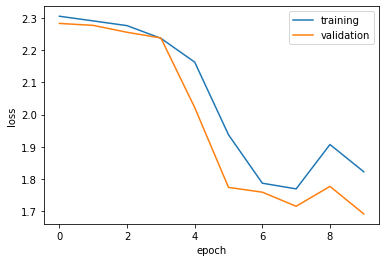

In [55]:
#@title Training and validation loss curves of an MDEQ model trained using implicit differentiation
# importing package
import matplotlib.pyplot as plt
  
# create data
train_loss_broyden = broyden_results['train_loss_vals']
val_loss_broyden = broyden_results['val_loss_vals']
epochs = np.arange(len(val_loss_broyden))
  
# plot lines
plt.plot(epochs, train_loss_broyden, label = "training")
plt.plot(epochs, val_loss_broyden, label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

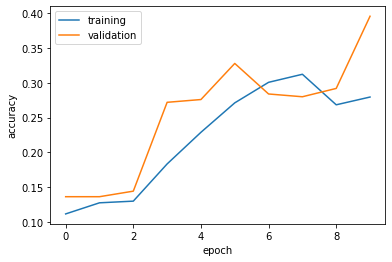

In [56]:
#@title Training and validation accuracy curves of an MDEQ model trained using implicit differentiation

# create data
train_acc_broyden = broyden_results['train_acc_vals']
val_acc_broyden = broyden_results['val_acc_vals']
  
# plot lines
plt.plot(epochs, train_acc_broyden, label = "training")
plt.plot(epochs, val_acc_broyden, label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The losses on both the training and validations set decreased over 10 epochs, while the accuracy increased. However, training time was appreciably slow (it took 40 mintes to train for 10 epochs on 2500 images and our model had not yet fully converged). 

Below, we also plot the average residuals $\frac{||f(z) - (z)||}{||(z)||}$ after running the Broyden solver to demonstrate the model's ability to learn a fixed point:

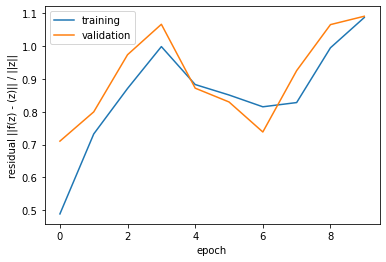

In [61]:
#@title Training and validation residual curves of an MDEQ model trained using implicit differentiation

# create data
train_res_broyden = broyden_results['train_res_vals']
val_res_broyden = broyden_results['val_res_vals']
  
# plot lines
plt.plot(epochs, train_res_broyden, label = "training")
plt.plot(epochs, val_res_broyden, label = "validation")
plt.xlabel("epoch")
plt.ylabel("residual ||f(z) - (z)|| / ||z||")
plt.legend()
plt.show()

Interestingly, the average residual increased during training (with local decreases). We hypothesize this occurred because finding the fixed point problem is harder to solve as the function becomes more complicated. In a follow up work from [Kolter et al.](https://arxiv.org/abs/2106.14342), they noticed that training DEQ models is highly dependent on the architecture and also saw the norm of the residual increased during trianing. More complicated functions are harder to solve for fixed points, and various architectures can render the model unstable. Thus, it's possible we weren't able to replicate the results well from the MDEQ paper because we did not not have the same architecture / training setup (we adapted a smaller version to run in Colab). 

------------------------------------------------------------
# Experiment #2: MDEQ trained using direct solving vs implicit differentiation

In [48]:
ds_results = train(mode="non_implicit", solver='direct')

NUM TRAINING IMAGES:::2500
NUM TEST IMAGES:::250
TRAINING MODE:::non_implicit


/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:371: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


> epoch 1, batch 1 :: batch_loss = 2.3379976749420166, batch_acc = 0.1015625, batch_res = 0.5847600698471069 
> epoch 1, batch 2 :: batch_loss = 2.3374249935150146, batch_acc = 0.109375, batch_res = 0.5406241416931152 
> epoch 1, batch 3 :: batch_loss = 2.3311376571655273, batch_acc = 0.125, batch_res = 0.5126174688339233 
> epoch 1, batch 4 :: batch_loss = 2.3318088054656982, batch_acc = 0.171875, batch_res = 0.47527456283569336 
> epoch 1, batch 5 :: batch_loss = 2.3052122592926025, batch_acc = 0.1484375, batch_res = 0.44983774423599243 
> epoch 1, batch 6 :: batch_loss = 2.30183744430542, batch_acc = 0.1171875, batch_res = 0.43026214838027954 
> epoch 1, batch 7 :: batch_loss = 2.302621364593506, batch_acc = 0.1171875, batch_res = 0.40320971608161926 
> epoch 1, batch 8 :: batch_loss = 2.3030123710632324, batch_acc = 0.1015625, batch_res = 0.3941414952278137 
> epoch 1, batch 9 :: batch_loss = 2.310709238052368, batch_acc = 0.0703125, batch_res = 0.38724976778030396 
> epoch 1, batc

Below, we plot the accuracy and loss curves for the validation sets after training the MDEQ model using an implicit or explicit solver.

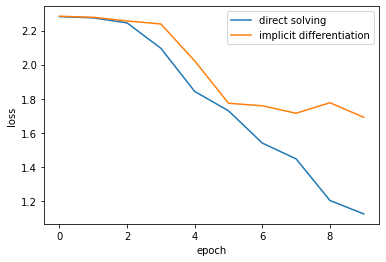

In [58]:
#@title Validation loss curves of MDEQ models trained using implicit differentiation vs direct solving
# importing package

# create data
val_loss_ds = ds_results['val_loss_vals']
val_loss_broyden = broyden_results['val_loss_vals']
epochs = np.arange(len(val_loss_broyden))
  
# plot lines
plt.plot(epochs, val_loss_ds, label = "direct solving")
plt.plot(epochs, val_loss_broyden, label = "implicit differentiation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

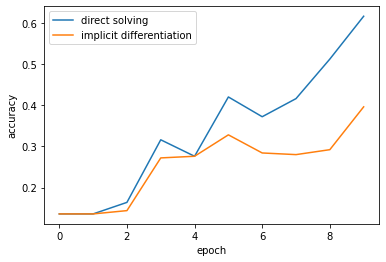

In [59]:
#@title Validation accuracy curves of MDEQ models trained using implicit differentiation vs direct solving

# create data
val_acc_ds = ds_results['val_acc_vals']
val_acc_broyden = broyden_results['val_acc_vals']
epochs = np.arange(len(val_loss_broyden))
  
# plot lines
plt.plot(epochs, val_acc_ds, label = "direct solving")
plt.plot(epochs, val_acc_broyden, label = "implicit differentiation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

The model trained during direct solving was able to converge much faster and get much better performance. However, the residuals are much larger:

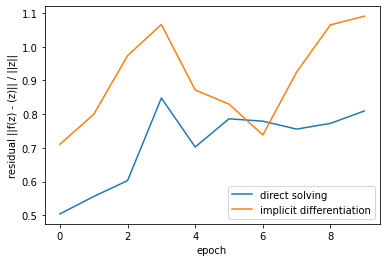

In [60]:
#@title Validation residual curves of MDEQ models trained using explicit vs implicit differentiation

# create data
val_res_ds = ds_results['val_res_vals']
val_res_broyden = broyden_results['val_res_vals']
  
# plot lines
plt.plot(epochs, val_res_ds, label = "direct solving")
plt.plot(epochs, val_res_broyden, label = "implicit differentiation")
plt.xlabel("epoch")
plt.ylabel("residual ||f(z) - (z)|| / ||z||")
plt.legend()
plt.show()

------------------------------------------------------------------
# Experiment #3: MDEQ trained with implicit differentiation using warm-up

We experiment with running a shallow (5-layer) weight-tied direct solver as a pre-training step, and then using those weights to initialize the the MDEQ model trained with implicit differentiation. The motivation is that the model used for pre-training is much cheaper (faster) to run, while pushing gradients generally in the optimal direction. We then train the model using the implicit MDEQ paradigm; we hypothesize the model is then able to find the roots of the equation $f(z) - (z)$ more quickly since it has to call the (expensive) optimizer less times.

In [ ]:
warmup_results = train(mode="warmup", solver='broyden')